In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from scipy.interpolate import pchip_interpolate
from scipy import interpolate, signal

In [18]:
# Functions
#_______________________________________________________________________________
def Load_Files(dir):
    data={}
    entries = os.listdir(dir)
    titles= ['Sensor','TimeStamp','Roll','Pitch','Heading','xGyr','yGyr','zGyr','BatteryLVL']
    for i in entries:
        if 'SENSOR'in i:
            name= i.split('.')
            s = pd.read_csv(dir + i, sep=",")
            s.columns= titles
            s.loc[:,'TimeStamp']= s.loc[:,'TimeStamp']/1000
            data[name[0]] = s
    return data
#_______________________________________________________________________________
def Plot_Data(data):
  """
  This fuction plot the Roll, Pitch and Heading data.
  """

  fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(10,15))
  for i in data:
    s= data[i]
    ax1.plot(s.loc[:,'TimeStamp'],s.loc[:,'Roll'], label= i)
    ax2.plot(s.loc[:,'TimeStamp'],s.loc[:,'Pitch'], label= i)
    ax3.plot(s.loc[:,'TimeStamp'],s.loc[:,'Heading'], label= i)
  ax1.legend()
  ax1.set_xlabel('Time (s)')
  ax1.set_ylabel('Roll (°)')
  ax1.set_title('Roll')
  ax2.legend()
  ax2.set_xlabel('Time (s)')
  ax2.set_ylabel('Pitch (°)')
  ax2.set_title('Pitch')
  ax3.legend()
  ax3.set_xlabel('Time (s)')
  ax3.set_ylabel('Heading (°)')
  ax3.set_title('Heading')
  plt.show()
  return None
#_______________________________________________________________________________
def Set_Data(data):
  """
  This fuction set the sensors to start in 0.
  """
  for i in data:
    s= data[i]
    s= s.iloc[50:data[i].size-29,:]                                             #errase first 50 takes and last 29
    time= s.loc[:,"TimeStamp"]
    time= time-time.iloc[0]
    s.loc[:,'TimeStamp']= time
    data[i]= s
  return data 
#_______________________________________________________________________________
def Delete_Peaks(data,thresh=89):
  """
  This fuction fix the angles lokking for the abrupt changes.
  """
  for i in data: 
    old_data= data[i].iloc[:,1:4]
    new_data= old_data
    i_d= 1
    for d in range(0,len(old_data.columns)-1):
      for f in range(1,len(old_data)-1):  
        dif= new_data.iloc[f,d]-new_data.iloc[f-1,d]
        if abs(dif)> thresh:
          if i_d == 1:
            i_d=0
            inc= f
            chg=-new_data.iloc[f,d]-new_data.iloc[f-1,d]
          elif i_d == 0:
            new_data.iloc[inc:f-1,d]=-old_data.iloc[inc:f-1,d]-chg
            i_d=1
    data[i].iloc[:,1:4]= new_data
  return data
#_______________________________________________________________________________
def Resample(data, f):
  """
  This fuction resample the data to a frecuency passed by the user.
  """
  for i in data:
    s= data[i]
    n_t= s.loc[:,'TimeStamp']
    n_t= n_t-n_t.iloc[0]
    n_t= np.linspace(0,n_t.iloc[-1], round(n_t.iloc[-1]*f))
    r= s.loc[:,'Roll']
    p= s.loc[:,'Pitch']
    h= s.loc[:,'Heading']
    x= s.loc[:,'xGyr']
    y= s.loc[:,'yGyr']
    z= s.loc[:,'zGyr']
    r= pchip_interpolate(s.loc[:,'TimeStamp'],r,n_t)
    p= pchip_interpolate(s.loc[:,'TimeStamp'],p,n_t)
    h= pchip_interpolate(s.loc[:,'TimeStamp'],h,n_t)
    x= pchip_interpolate(s.loc[:,'TimeStamp'],x,n_t)
    y= pchip_interpolate(s.loc[:,'TimeStamp'],y,n_t)
    z= pchip_interpolate(s.loc[:,'TimeStamp'],z,n_t)
    s= pd.DataFrame({'TimeStamp':n_t, 'Roll':r, 'Pitch':p, 'Heading':h, 'xGyr':x, 'yGyr':y, 'zGyr':z})
    data[i]= s
  return data
#_______________________________________________________________________________
""" this function Syncronize the data from the sensors"""
#_______________________________________________________________________________
def Rotation_Matrix(Roll, Pitch, Heading):
  """ 
  This fuction determine the Rotation Matrix from the Euler Angles 
  (Roll, Pitch, Heading) with the XYZ convention of the sensors.
  """
  R_x = np.array([[1, 0, 0],
                  [0, np.cos(Roll), -np.sin(Roll)],
                  [0, np.sin(Roll), np.cos(Roll)]])
  R_y = np.array([[np.cos(Pitch), 0, np.sin(Pitch)],
                  [0, 1, 0],
                  [-np.sin(Pitch), 0, np.cos(Pitch)]])
  R_z = np.array([[np.cos(Heading), -np.sin(Heading), 0],
                  [np.sin(Heading), np.cos(Heading), 0],
                  [0, 0, 1]])
  R = np.dot(R_z, np.dot(R_y, R_x))
  return R

def Get_Rotation_Matrix(data):
  """
  This fuction determine the Rotation Matrix from the Euler Angles 
  (Roll, Pitch, Heading) with the XYZ convention of the sensors.
  """
  Rot_Mtx={}
  for i in data:
    s= data[i]
    R= np.zeros((len(s),3,3))
    for j in range(0,len(s)):
      R[j,:,:]= Rotation_Matrix(s.iloc[j,1],s.iloc[j,2],s.iloc[j,3])
    Rot_Mtx[i]= R
  return Rot_Mtx


C:\Users\Jose Amorocho\AppData\Local\Temp\ipykernel_107120\2266360741.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s.loc[:,'TimeStamp']= time


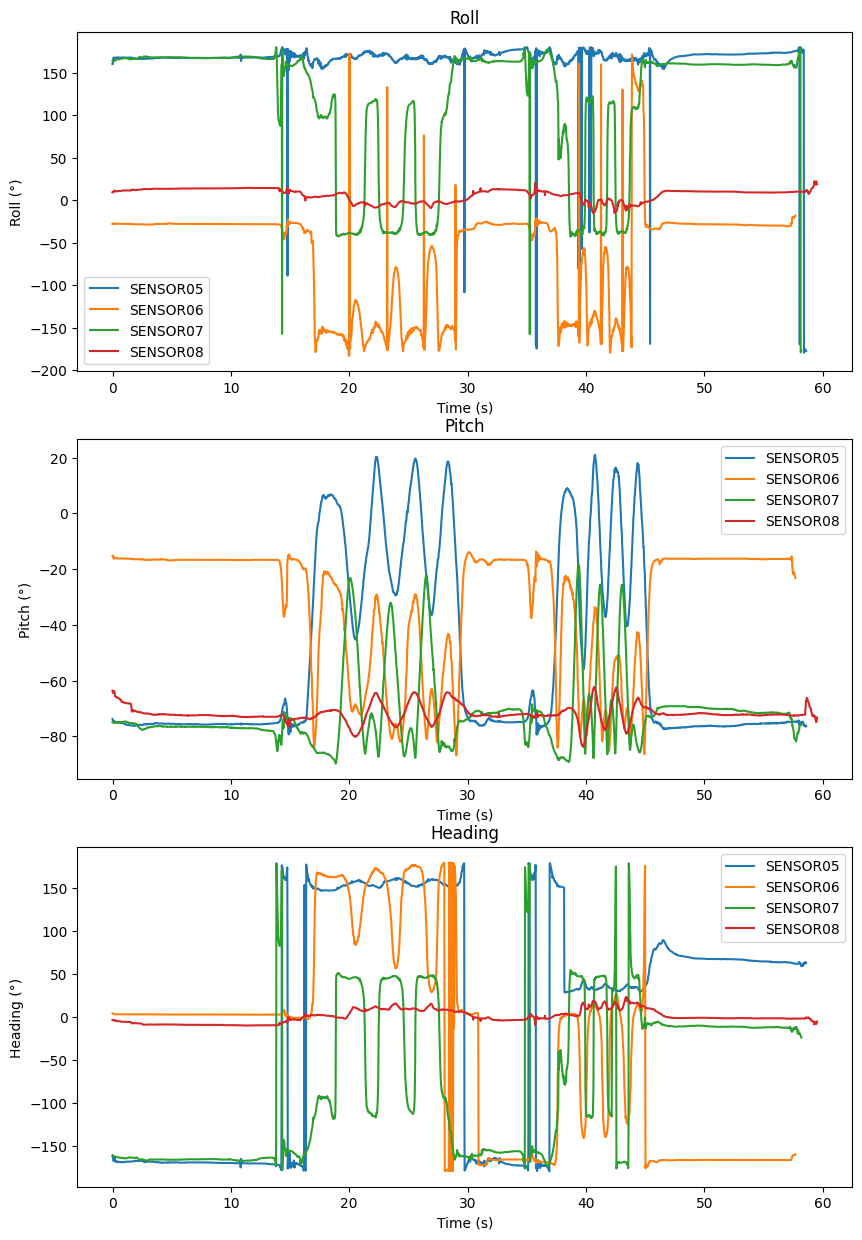

In [37]:
#test= input('put the name test:')
test= 'FECad_p1'
dir="D:/_Proyecto-SAM/2022-02-01/"+test+'/'

# Load the data
data= Load_Files(dir)
# Set Start to 0 Sensors(SAM).
data= Set_Data(data)
# Fix angle.
data= Delete_Peaks(data)
# Over-sample to 200Hz.
data= Resample(data,200)
# Syncronize the data.

# Sample to 50Hz.
data= Resample(data,50)
# Plot the data.
Plot_Data(data)

In [38]:
Rot_Mtx= Get_Rotation_Matrix(data)
Rot_Mtx

{'SENSOR05': array([[[-0.00566255,  0.99989522,  0.01332237],
         [-0.02683294,  0.01316586, -0.99955323],
         [-0.99962389, -0.0060175 ,  0.02675558]],
 
        [[ 0.08359701,  0.95752321, -0.27597254],
         [ 0.15009278, -0.2858814 , -0.94643752],
         [-0.98513131,  0.03769786, -0.16761615]],
 
        [[ 0.400979  , -0.21490878,  0.89052235],
         [-0.36469927,  0.85429112,  0.37037971],
         [-0.84036319, -0.47328734,  0.26417572]],
 
        ...,
 
        [[ 0.40076134, -0.59995595, -0.69241838],
         [ 0.47325017,  0.7826909 , -0.4042638 ],
         [ 0.78449004, -0.16567381,  0.59760151]],
 
        [[ 0.54921237, -0.00933926, -0.83563063],
         [ 0.53065837,  0.7763616 ,  0.34009463],
         [ 0.6455753 , -0.63021856,  0.43134335]],
 
        [[ 0.52438949,  0.79284733,  0.31049762],
         [-0.12380777, -0.28978395,  0.94905052],
         [ 0.8424294 , -0.53611414, -0.053799  ]]]),
 'SENSOR06': array([[[ 0.52764859, -0.84946003,  0.0021